In [341]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

import geopandas
from shapely.geometry import Polygon
import contextily as ctx

from ast import literal_eval
import random

from modules.data_aggregation.satellite_data import create_gdf, export_gdf, import_gdf_from_shp

from modules.data_aggregation.params import CITY_BOUNDING_BOXES
from modules.ml_logic.utils import slice_picture_coords, get_sub_tile, get_all_sub_coords, get_corners

# Building data from OSMnx

In [8]:
import osmnx

from modules.data_aggregation.params import CITY_BOUNDING_BOXES

In [9]:
bb_Paris = CITY_BOUNDING_BOXES['Paris']
bb_Paris

[[2.264216, 2.42172], [48.813898, 48.900502]]

In [20]:
tags = {"building": True, 'height': True, 'landuse': True}
building_landuse_data = osmnx.geometries.geometries_from_bbox(bb_Paris[1][1], bb_Paris[1][0], bb_Paris[0][1], bb_Paris[0][0],
                                      tags = tags)

In [26]:
from shapely.geometry import Polygon, LineString, Point

def data_preprocessing(raw_buildings):
    # Data preprocessing
    raw_buildings.reset_index(inplace = True) # remove index
    if 'height' not in raw_buildings.columns:
        raise Exception("\n\nWe could not find the height data for this location. Please choose another location.\n\n") 
    buildings = raw_buildings[['height','geometry']] # new dataframe with only the col needed
    buildings['building_id'] = range(len(buildings))
    buildings = buildings[buildings['height'].notna()] # remove na of height
    buildings = buildings[buildings['geometry'].apply(lambda x: (not isinstance(x, Point) and not isinstance(x, LineString)))]
    buildings['height'] = buildings['height'].str.split(';') # split heights when there are more than one
    buildings['height'] = buildings['height'].apply(lambda x: max(x)) # select the heighest value
    buildings['height']= pd.to_numeric(buildings['height'], errors='coerce')
    
    return buildings

In [28]:
prep_building = data_preprocessing(building_landuse_data)

/Users/bfc/.pyenv/versions/3.10.6/envs/future_proofing_cities/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot: >

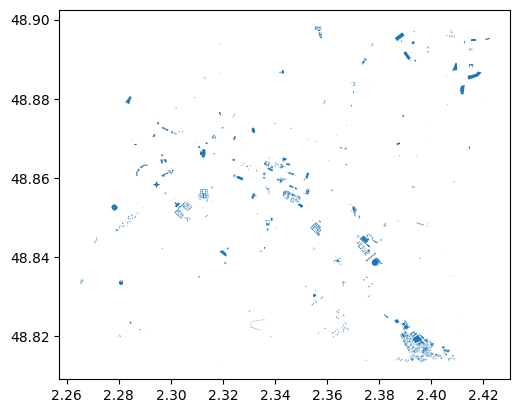

In [30]:
prep_building.plot()

In [25]:
building_landuse_data[['height','geometry','landuse']]

height  \
element_type osmid              
node         277055631    NaN   
             326372977     11   
             327419531    NaN   
             465294103   11.5   
             676788794      3   
...                       ...   
relation     14785931     NaN   
             14866045     NaN   
             14878474     NaN   
             14883881     NaN   
             14907318     NaN   

                                                                 geometry  \
element_type osmid                                                          
node         277055631                           POINT (2.35647 48.84040)   
             326372977                           POINT (2.34729 48.85219)   
             327419531                           POINT (2.35211 48.86183)   
             465294103                           POINT (2.27970 48.85002)   
             676788794                           POINT (2.34300 48.85576)   
...                                                                   ...   
relation     14785931   POLYGON ((2.31171 48.84718, 2.31169 48.84717, ...   
             14866045   POLYGON ((2.29282 48.83712, 2.29285 48.83710, ...   
             14878474   POLYGON ((2.29472 48.84492, 2.29471 48.84491, ...   
             14883881   POLYGON ((2.30127 48.86490, 2.30128 48.86490, ...   
             14907318   MULTIPOLYGON (((2.37758 48.88080, 2.37764 48.8...   

                       landuse  
element_type osmid              
node         277055631     NaN  
             326372977     NaN  
             327419531     NaN  
             465294103     NaN  
             676788794     NaN  
...                        ...  
relation     14785931    grass  
             14866045      NaN  
             14878474      NaN  
             14883881      NaN  
             14907318      NaN  

[221320 rows x 3 columns]

In [31]:
import overpy

In [32]:
api = overpy.Overpass()

In [37]:
api.query("[out:json];node(50.745,7.17,50.75,7.18);out;")

# Importing processed satellite data

In [11]:
# import GeoDataFrame
gdf_Paris_import = import_gdf_from_shp("Paris")
gdf_Berlin_import = import_gdf_from_shp("Berlin")

In [12]:
gdf_Paris_import.sample(2)

LST        ele  LST_diff   ele_diff  \
7439   24.250000  88.248856 -6.555969  14.487213   
28650  27.790009  72.583771 -3.015961  -1.177872   

                                      ul_corner  \
7439   [[2.345799523449589, 48.83146774266705]]   
28650  [[2.3728708716127658, 48.8843513065207]]   

                                        ll_corner  \
7439     [[2.345799523449589, 48.83209730890341]]   
28650  [[2.3728708716127658, 48.884980872757055]]   

                                        lr_corner  \
7439     [[2.346429089685942, 48.83209730890341]]   
28650  [[2.3735004378491187, 48.884980872757055]]   

                                      ur_corner  \
7439   [[2.346429089685942, 48.83146774266705]]   
28650  [[2.3735004378491187, 48.8843513065207]]   

                                                      bb  \
7439   [[2.345799523449589, 48.83146774266705], [2.34...   
28650  [[2.3728708716127658, 48.8843513065207], [2.37...   

                                                geometry  
7439   POLYGON ((2.34580 48.83147, 2.34580 48.83210, ...  
28650  POLYGON ((2.37287 48.88435, 2.37287 48.88498, ...

In [13]:
gdf_Berlin_import.sample(2)

LST         ele  LST_diff   ele_diff  \
1020  25.529999  178.031952  9.508221 -23.861374   
8779  22.230011  174.798767  6.208233 -27.094559   

                                       ul_corner  \
1020   [[13.323223947662463, 52.47770910570899]]   
8779  [[13.467403298991488, 52.496597230337244]]   

                                       ll_corner  \
1020  [[13.323223947662463, 52.478338709863266]]   
8779   [[13.467403298991488, 52.49722683449152]]   

                                       lr_corner  \
1020  [[13.323853551816738, 52.478338709863266]]   
8779   [[13.468032903145764, 52.49722683449152]]   

                                       ur_corner  \
1020   [[13.323853551816738, 52.47770910570899]]   
8779  [[13.468032903145764, 52.496597230337244]]   

                                                     bb  \
1020  [[13.323223947662463, 52.47770910570899], [13....   
8779  [[13.467403298991488, 52.496597230337244], [13...   

                                               geometry  
1020  POLYGON ((13.32322 52.47771, 13.32322 52.47834...  
8779  POLYGON ((13.46740 52.49660, 13.46740 52.49723...

In [14]:
# import DataFrame
df_Paris_import = pd.read_csv('../../data/processed_data/Paris/Paris.csv')
df_Berlin_import = pd.read_csv('../../data/processed_data/Berlin/Berlin.csv')

In [15]:
df_Berlin_import.sample(5)

LST        ele  LST_diff   ele_diff  \
11256  20.070007  189.28975  4.048229 -12.603577   
30536  15.809998  232.36522 -0.211781  30.471893   
10555  10.670013  214.30440 -5.351765  12.411072   
10344  14.829987  195.83000 -1.191791  -6.063324   
28103   9.130005  188.19847 -6.891773 -13.694855   

                                        ul_corner  \
11256      [[13.446626361900407, 52.50289327188]]   
30536    [[13.41703496664947, 52.55137279175919]]   
10555   [[13.321335135199638, 52.50163406357145]]   
10344  [[13.346519301370646, 52.501004459417175]]   
28103   [[13.465514486528663, 52.54507675021644]]   

                                        ll_corner  \
11256  [[13.446626361900407, 52.503522876034275]]   
30536    [[13.41703496664947, 52.55200239591347]]   
10555   [[13.321335135199638, 52.50226366772573]]   
10344   [[13.346519301370646, 52.50163406357145]]   
28103  [[13.465514486528663, 52.545706354370715]]   

                                        lr_corner  \
11256  [[13.447255966054682, 52.503522876034275]]   
30536   [[13.417664570803746, 52.55200239591347]]   
10555   [[13.321964739353913, 52.50226366772573]]   
10344   [[13.347148905524922, 52.50163406357145]]   
28103  [[13.466144090682938, 52.545706354370715]]   

                                        ur_corner  \
11256      [[13.447255966054682, 52.50289327188]]   
30536   [[13.417664570803746, 52.55137279175919]]   
10555   [[13.321964739353913, 52.50163406357145]]   
10344  [[13.347148905524922, 52.501004459417175]]   
28103   [[13.466144090682938, 52.54507675021644]]   

                                                      bb  
11256  [[13.446626361900407, 52.50289327188], [13.446...  
30536  [[13.41703496664947, 52.55137279175919], [13.4...  
10555  [[13.321335135199638, 52.50163406357145], [13....  
10344  [[13.346519301370646, 52.501004459417175], [13...  
28103  [[13.465514486528663, 52.54507675021644], [13....

In [7]:
# basic info

print(f"mean temp: {gdf_Paris_import.LST.mean()}, mean elevation: {gdf_Paris_import.ele.mean()}")
print(f"mean diff temp: {gdf_Paris_import.LST_diff.mean()}, mean diff elevation: {gdf_Paris_import.ele_diff.mean()}")
print(f"min temp: {gdf_Paris_import.LST.min()}, min elevation: {gdf_Paris_import.ele.min()}")
print(f"max temp: {gdf_Paris_import.LST.max()}, max elevation: {gdf_Paris_import.ele.max()}")
print(f"min diff temp: {gdf_Paris_import.LST_diff.min()}, min diff elevation: {gdf_Paris_import.ele_diff.min()}")
print(f"max diff temp: {gdf_Paris_import.LST_diff.max()}, max diff elevation: {gdf_Paris_import.ele_diff.max()}")


mean temp: 30.805967938400396, mean elevation: 73.76163836038451
mean diff temp: -1.2998808542451752e-06, mean diff elevation: -4.095670171452124e-06
min temp: 19.07000732421875, min elevation: 45.577308654785156
max temp: 41.329986572265625, max elevation: 135.3814697265625
min diff temp: -11.7359619140625, min diff elevation: -28.18433380126953
max diff temp: 10.524017333984375, max diff elevation: 61.61982727050781


# Importing raw satellite data 
has to be downloaded in '../../data/raw_data/{city_name}/*.h5'

In [172]:
# two different L2 files containing LST
lst_raw = h5py.File('../../data/raw_data/Paris/ECOSTRESS_L2_LSTE_23097_002_20220802T145219_0601_02.h5', 'r')

# L1 fille containing GPS coordinates
geo_raw = h5py.File('../../data/raw_data/Paris/ECOSTRESS_L1B_GEO_23097_002_20220802T145219_0601_01.h5', 'r')

In [173]:
lst_raw_array = np.array(lst_raw['SDS']['LST'], dtype = np.float32)
lst_raw_array.shape

(5632, 5400)

In [178]:
np.vstack((lst_raw_array, lst_raw_array)).shape

(11264, 5400)

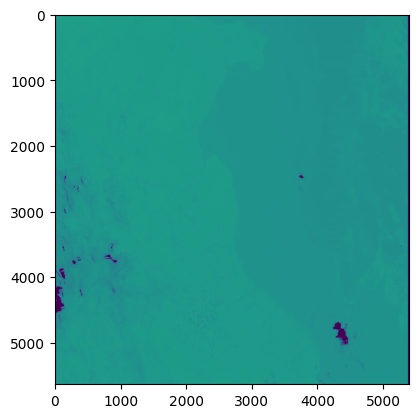

In [174]:
plt.imshow(lst_raw_array)

# Creating processed data
(if raw data availabe)

In [ ]:
# create GeoDataFrame
gdf_Paris = create_gdf("Paris")

KeyboardInterrupt: 

In [ ]:
gdf_Paris[1]['bb'][0]

[[2.2633263464873545, 48.81321032181281],
 [2.2633263464873545, 48.813839888049166],
 [2.2639559127237074, 48.813839888049166],
 [2.2639559127237074, 48.81321032181281]]

In [ ]:
gdf_Paris[1]['bb'][0]

[[2.2639559127237074, 48.81321032181281],
 [2.2639559127237074, 48.813839888049166],
 [2.2633263464873545, 48.813839888049166],
 [2.2633263464873545, 48.81321032181281]]

In [ ]:
# create & export GeoDataFrame
export_gdf("Paris")

# Plotting

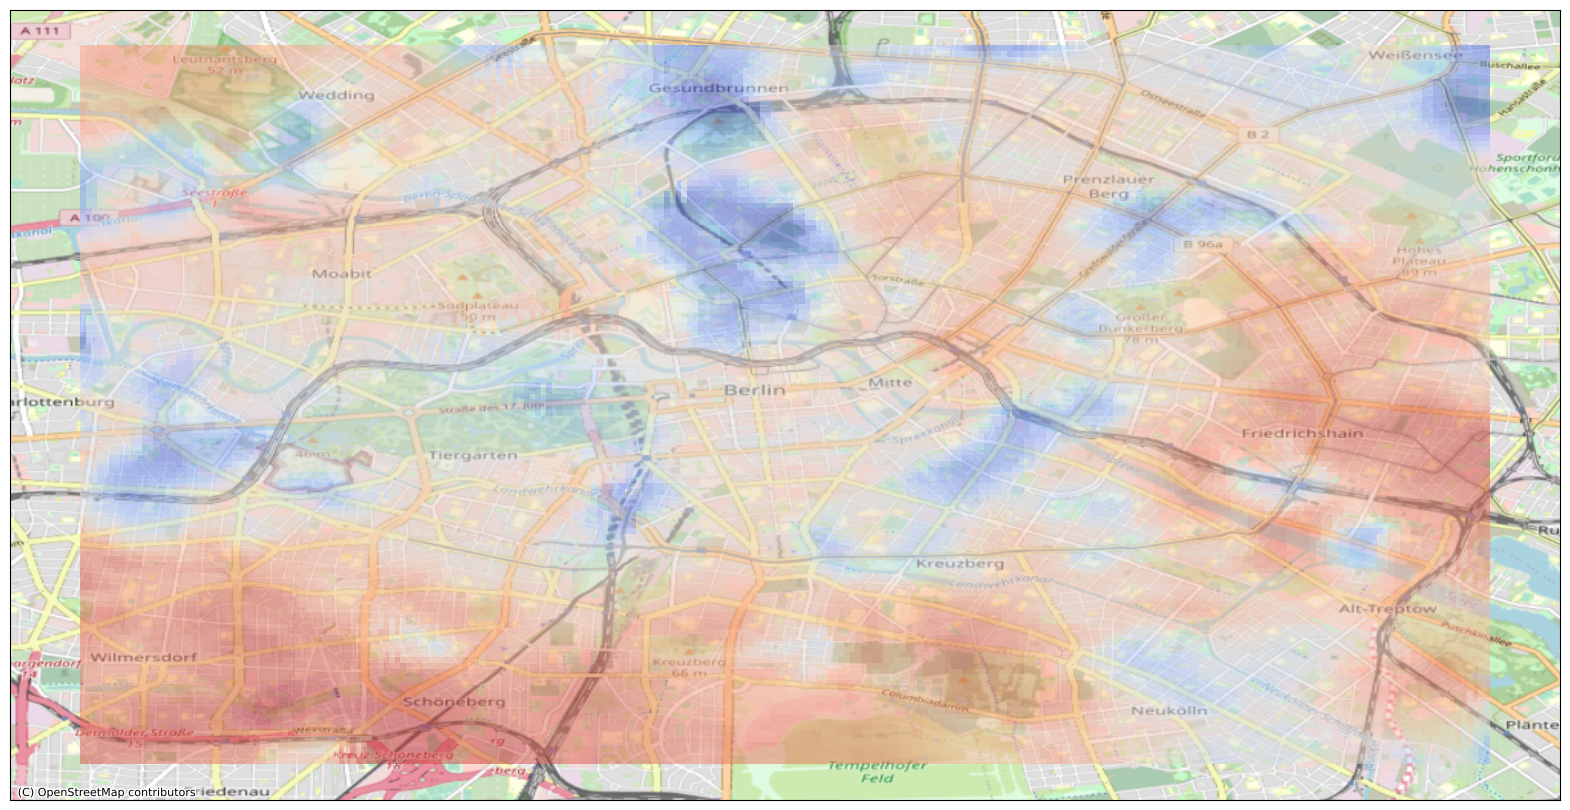

In [23]:
fig, ax = plt.subplots(figsize = (20,15))
gdf_Berlin_import.plot(column = 'LST', ax = ax, alpha = .5, cmap = 'coolwarm')
ctx.add_basemap(ax,  crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.savefig('Berlin_plot.png')
plt.savefig('Berlin_plot.pdf') 

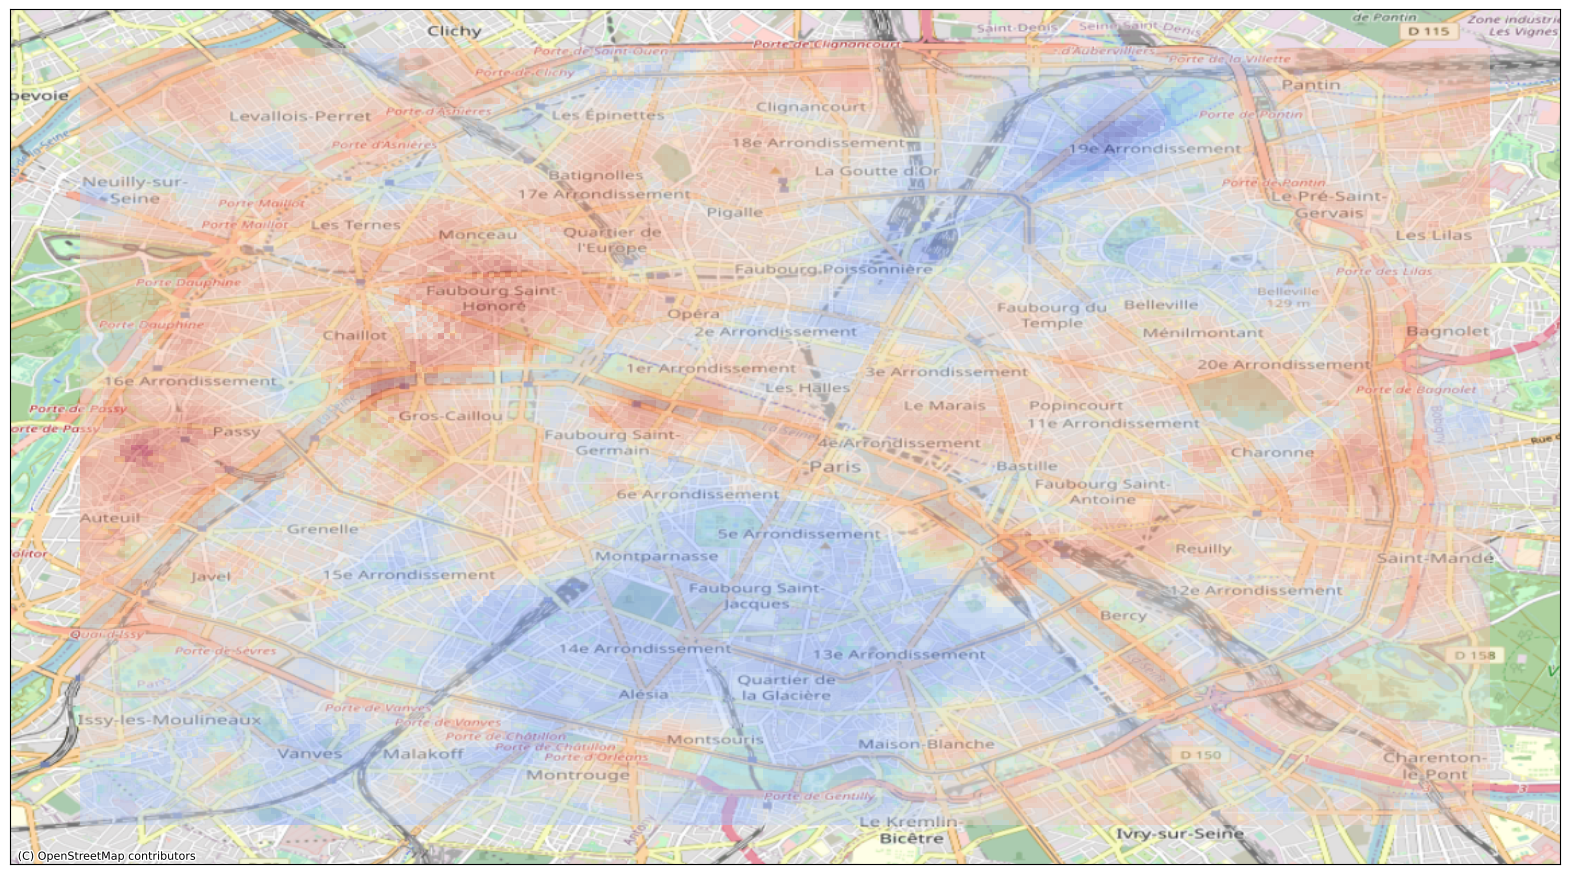

In [22]:
fig, ax = plt.subplots(figsize = (20,15))
gdf_Paris_import.plot(column = 'LST', ax = ax, alpha = .5, cmap = 'coolwarm')
ctx.add_basemap(ax,  crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig('Paris_plot.png')
plt.savefig('Paris_plot.pdf')  

# Slicing of image

In [268]:
def get_split_indices(data_array: np.array, number_features: int):
    """
    returns index where array has to be split
    """
    return len(data_array)/number_features

int(get_split_indices(subtiles_array_0.values[0], number_features))

4

In [269]:
def split_array(data_array: np.array, split_index:int):
    """
    returns split array
    """
    return [data_array[i:i+split_index] for i in range(0,len(data_array), split_index)]

In [532]:
import os

# processed data
INPUT_PATH = os.path.join('..','..','data','processed_data')

In [615]:
def get_sub_tiles(data: pd.DataFrame, num_px_lon: int, num_px_lat:int):
    
    # reduce size of df
    if 'geometry' in data.columns: 
        df_red = data.drop(columns=['LST', 'ele','ll_corner', 'ur_corner', 'lr_corner','bb', 'geometry'])
    else: 
        df_red = data.drop(columns=['LST', 'ele','ll_corner', 'ur_corner', 'lr_corner','bb'])

    # convert str to list
    df_red['ul_corner'] = df_red.ul_corner.apply(literal_eval)
    
    # separate into lat and lon
    df_red['lon'] = np.array([row[0] for row in df_red.ul_corner])[:,0]
    df_red['lat'] = np.array([row[0] for row in df_red.ul_corner])[:,1]
    
    # set lon, lat as index and unstack 
    data_coord_array = df_red.set_index(['lon', 'lat']).unstack().sort_index()
    data_array = data_coord_array.drop(columns = 'ul_corner').values
    coord_array = data_coord_array['ul_corner'].values

    # split data array
    number_features = len(df_red.columns)-3 # minus lat, lon, ul_corner
    split_index_data = int(get_split_indices(data_array[0], number_features))
    
    # transform data_array
    data_array_trans = np.array([np.array(split_array(array, split_index_data)).T for array in data_array])
    
    # split coords array
    split_index_coord = int(get_split_indices(coord_array[0], 1))
    
    # transform coord_array
    coord_array_trans = np.array([np.array(split_array(array, split_index_coord)).T for array in coord_array])
    
    lon_dim, lat_dim = data_array_trans.shape[:2]
    
    lon_range = range(0, lon_dim - num_px_lon, num_px_lon)
    lat_range = range(0, lat_dim - num_px_lat, num_px_lat)

    # divide data and coords into subtiles
    data_tiles = np.array([data_array_trans[i:i+num_px_lon, j:j+num_px_lat, :] for i in lon_range for j in lat_range])
    coord_tiles = np.array([coord_array_trans[i:i+num_px_lon, j:j+num_px_lat, :] for i in lon_range for j in lat_range])
    
    # print(coord_tiles[0])
    
    # select just the coord tiles boundaries
    coord_bb = np.array([[[coords[j,0,0][0][0], coords[j,0,-1][0][0]], [coords[j,0,0][0][1], coords[j,0,-1][0][1]]] for coords in coord_tiles\
                            for j in range(coord_tiles.shape[1])])
    
    
    return data_tiles, coord_tiles, coord_bb

In [555]:
def tile_whole_city(city:str, num_px_lon: int = 32, num_px_lat: int = 32):

    # import csv data
    data_in_path = os.path.join(INPUT_PATH, city, f'{city}.csv')
    print(data_in_path)

    data = pd.read_csv(data_in_path)
    data_tiles, coord_bb = get_sub_tiles(data, num_px_lon, num_px_lat)
    print(data_tiles.shape)

    # export both data and coords bounding boxes
    data_ex_path = os.path.join(INPUT_PATH, city, f'{city}_data_tiles_{num_px_lon}_{num_px_lat}.npy')
    coords_ex_path = os.path.join(INPUT_PATH, city, f'{city}_coordbb_tiles_{num_px_lon}_{num_px_lat}.npy')

    np.save(data_ex_path, data_tiles)
    np.save(coords_ex_path, coord_bb)

    return data_tiles, coord_bb

In [617]:
coord_tiles = get_sub_tiles(gdf_Paris_import, 32, 32)[1]

In [906]:
lr_corner = np.array([corner for corner in df_Paris_import['lr_corner'].apply(literal_eval)])
ul_corner = np.array([corner for corner in df_Paris_import['ul_corner'].apply(literal_eval)])

#one point
corner_diff_lon, corner_diff_lat = (lr_corner-ul_corner)[0,0,0], (lr_corner-ul_corner)[0,0,1]
corner_diffs = [[corner_diff_lon/2, 0], [0,0], [0, corner_diff_lat/2], [corner_diff_lon/2, corner_diff_lat/2]]

# sub_corners = [[ul_corner[i].tolist()[0], (ul_corner + corner_diff/2)[i].tolist()[0], lr_corner[i].tolist()[0]] for i in range(ul_corner.shape[0])]
corner_diff_lon, corner_diff_lat 

(0.0006295662363529075, 0.0006295662363555721)

In [936]:
(lr_corner-ul_corner)[:,0,1][0]

0.0006295662363555721

In [977]:
def get_subpoints_one(point: list, lon_lat_dist: list, scaling_factor: int = 2):
    """
    returns point, divided by scaling_factor
    """
    diff_lon, diff_lat = lon_lat_dist
    #one point
    corner_diffs = [[[diff_lon/scaling_factor, 0], [0,0], [0, diff_lat/scaling_factor], [diff_lon/scaling_factor, diff_lat/scaling_factor]], # first four subpoints
                    [[diff_lon, 0], [diff_lon/scaling_factor,0], [diff_lon/scaling_factor, diff_lat/scaling_factor], [diff_lon, diff_lat/scaling_factor]], # second
                    [[0,diff_lat/scaling_factor], [0, diff_lat], [diff_lon/scaling_factor, diff_lat], [diff_lon/scaling_factor, diff_lat/scaling_factor]], # 3rd
                    [[diff_lon, diff_lat/scaling_factor], [diff_lon/scaling_factor,diff_lat/scaling_factor], [diff_lon/scaling_factor, diff_lat], [diff_lon, diff_lat]]] # 4th

    sub_points = point + corner_diffs
    
    return sub_points

In [978]:
get_subpoints_one(ul_corner[0,0], [corner_diff_lon, corner_diff_lat])

array([[[ 2.26364113, 48.81321032],
        [ 2.26332635, 48.81321032],
        [ 2.26332635, 48.8135251 ],
        [ 2.26364113, 48.8135251 ]],

       [[ 2.26395591, 48.81321032],
        [ 2.26364113, 48.81321032],
        [ 2.26364113, 48.8135251 ],
        [ 2.26395591, 48.8135251 ]],

       [[ 2.26332635, 48.8135251 ],
        [ 2.26332635, 48.81383989],
        [ 2.26364113, 48.81383989],
        [ 2.26364113, 48.8135251 ]],

       [[ 2.26395591, 48.8135251 ],
        [ 2.26364113, 48.8135251 ],
        [ 2.26364113, 48.81383989],
        [ 2.26395591, 48.81383989]]])

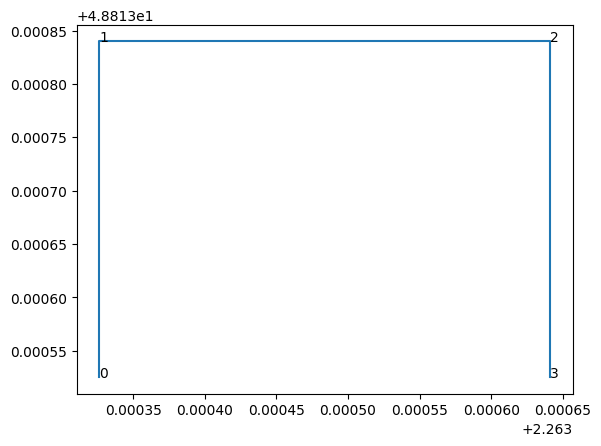

In [961]:
fig, ax = plt.subplots()

sub_points = get_subpoints_one(ul_corner[0,0], [corner_diff_lon, corner_diff_lat])[2]

x = sub_points[:,0]
y = sub_points[:,1]

ax.plot(x, y)

for i in range(4):
    ax.annotate(i, [x[i],y[i]])

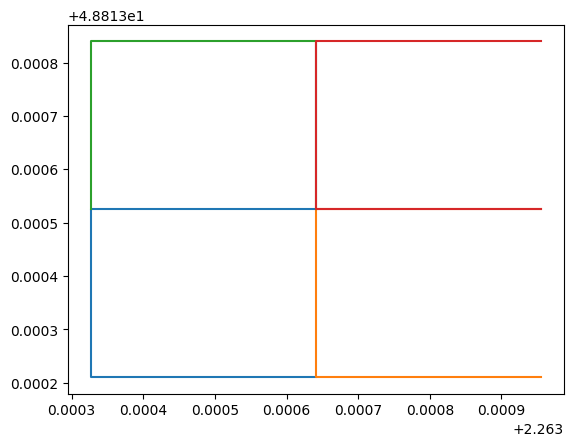

In [962]:
fig, ax = plt.subplots()

for i in range(4):
    sub_points =  get_subpoints_one(ul_corner[0,0], [corner_diff_lon, corner_diff_lat])[i]

    x = sub_points[:,0]
    y = sub_points[:,1]
    ax.plot(x, y)
    
    

In [963]:
def get_all_subpoints(data: pd.DataFrame):
    """
    returns all points divided by four
    """
    # ul, lr corners
    lr_corner = np.array([corner for corner in data['lr_corner'].apply(literal_eval)])
    ul_corner = np.array([corner for corner in data['ul_corner'].apply(literal_eval)])

    # difference between points
    corner_diff_lon_lat = np.array([(lr_corner-ul_corner)[:,0,0], (lr_corner-ul_corner)[:,0,1]]).T

    all_points = [get_subpoints_one(ul_corner[i],corner_diff_lon_lat[i]) for i in range(len(ul_corner))]

    return np.array(all_points).reshape(np.multiply(*np.array(all_points).shape[:2]),4,2)

In [ ]:
def subpixels_city(city:str):
    """
    saves subpixels of city to disk
    """
    
    
    subpixels = get_all_subpoints(data)

In [969]:
get_all_subpoints(df_Paris_import)

[array([[[ 2.26364113, 48.81321032],
         [ 2.26332635, 48.81321032],
         [ 2.26332635, 48.8135251 ],
         [ 2.26364113, 48.8135251 ]],
 
        [[ 2.26395591, 48.81321032],
         [ 2.26364113, 48.81321032],
         [ 2.26364113, 48.8135251 ],
         [ 2.26395591, 48.8135251 ]],
 
        [[ 2.26332635, 48.8135251 ],
         [ 2.26332635, 48.81383989],
         [ 2.26364113, 48.81383989],
         [ 2.26364113, 48.8135251 ]],
 
        [[ 2.26395591, 48.8135251 ],
         [ 2.26364113, 48.8135251 ],
         [ 2.26364113, 48.81383989],
         [ 2.26395591, 48.81383989]]]),
 array([[[ 2.2642707 , 48.81321032],
         [ 2.26395591, 48.81321032],
         [ 2.26395591, 48.8135251 ],
         [ 2.2642707 , 48.8135251 ]],
 
        [[ 2.26458548, 48.81321032],
         [ 2.2642707 , 48.81321032],
         [ 2.2642707 , 48.8135251 ],
         [ 2.26458548, 48.8135251 ]],
 
        [[ 2.26395591, 48.8135251 ],
         [ 2.26395591, 48.81383989],
         [ 2.2642707

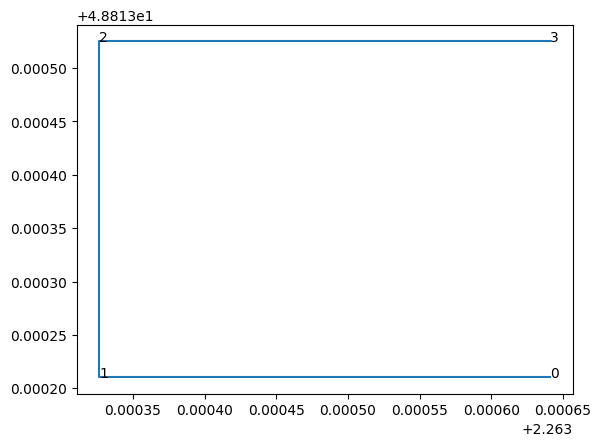

In [965]:
fig, ax = plt.subplots()

sub_points = get_all_subpoints(df_Paris_import)[0][0]

x = sub_points[:,0]
y = sub_points[:,1]

ax.plot(x, y)

for i in range(4):
    ax.annotate(i, [x[i],y[i]])

In [981]:
sub_points_full.shape

(140112, 4, 2)

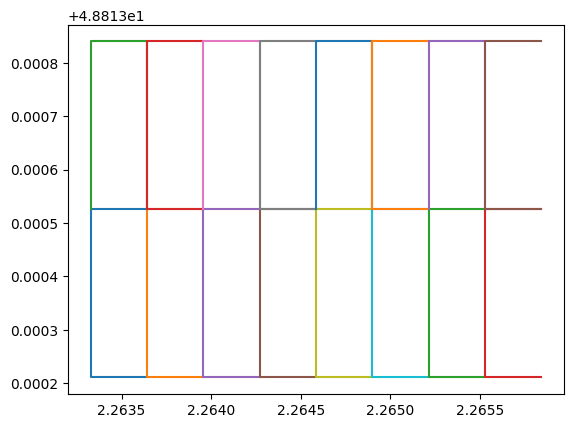

In [985]:
from modules.ml_logic.utils import import_subpixels
fig, ax = plt.subplots()
# sub_points_full =  get_all_subpoints(df_Paris_import)

sub_points_full = import_subpixels("Paris")

# sub_points_full = get_all_subpoints(df_Paris_import)[0]


for i in range(16):
    sub_points = sub_points_full[i]

    x = sub_points[:,0]
    y = sub_points[:,1]
    ax.plot(x, y)
    
    

In [597]:
tile_whole_city("Paris")

../../data/processed_data/Paris/Paris.csv
(28, 32, 32, 2)


(array([[[[-2.31597900e+00, -2.81843340e+01],
          [-2.79595950e+00, -2.81841740e+01],
          [-2.79595950e+00, -2.81841740e+01],
          ...,
          [ 1.58401490e+00, -2.71756600e+01],
          [ 1.58401490e+00, -2.71756600e+01],
          [ 1.06402590e+00, -2.61981010e+01]],
 
         [[-2.25598140e+00, -2.81842120e+01],
          [-1.69598390e+00, -2.81668550e+01],
          [-2.83596800e+00, -2.63573150e+01],
          ...,
          [ 1.58401490e+00, -2.71756600e+01],
          [ 1.34402470e+00, -2.71836850e+01],
          [ 1.34402470e+00, -2.71836850e+01]],
 
         [[-2.35595700e+00, -2.68145030e+01],
          [-2.83596800e+00, -2.70290070e+01],
          [-2.33596800e+00, -2.58000600e+01],
          ...,
          [ 1.38403320e+00, -2.71835370e+01],
          [ 1.08401490e+00, -2.57198640e+01],
          [ 1.06402590e+00, -2.50994220e+01]],
 
         ...,
 
         [[-4.01596070e+00, -2.81822550e+01],
          [-2.97598270e+00, -2.81820640e+01],
          

In [1]:
from modules.ml_logic.utils import import_data_array, import_bb_array

In [2]:
import_data_array("Paris").shape, import_bb_array("Paris").shape

((28, 32, 32, 2), (28, 2, 2))

In [5]:
bb_0 = np.array(get_corners([import_bb_array("Paris")[0]]))
bb_2 = np.array(get_corners([import_bb_array("Paris")[1]]))

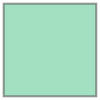

In [6]:
Polygon(get_corners(bb_2)[0])

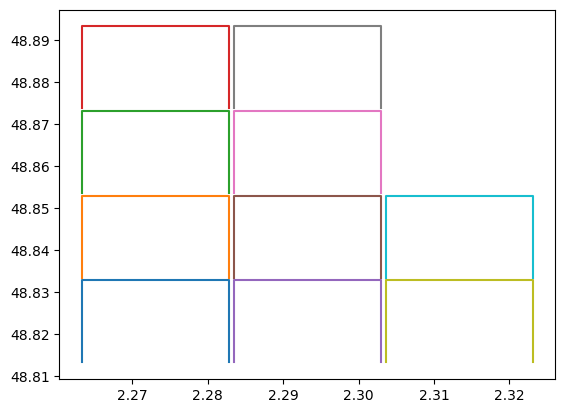

In [10]:
for i in range(10):
    plt.plot(np.array(get_corners([import_bb_array("Paris")[i]]))[0][:,0], np.array(get_corners([import_bb_array("Paris")[i]]))[0][:,1])


In [995]:
import_data_array("Paris").shape

(28, 32, 32, 2)

In [999]:
len([np.mean(tile) for tile in import_data_array("Paris")[:,:,:,0]])

28

In [1001]:
def get_average_temperature_per_tile(city: str) -> np.array: 
    """
    returns average temperature difference to mean temp 
    per tile for given city
    """
    import_data = import_data_array(city)
    
    return np.array([np.mean(tile) for tile in import_data[:,:,:,0]])

In [1004]:
get_average_temperature_per_tile("Paris")

array([-1.82171291,  2.42764359,  3.46422496,  0.92027982, -2.66403637,
       -0.92786497,  2.91701828,  1.76992845, -3.2228638 , -1.51659552,
        2.52514248,  2.59373622, -3.60061894, -4.67608688,  1.74975243,
        1.98203775, -3.78505153, -2.74821663,  0.21420562, -1.85186849,
       -0.58339206,  0.83041611,  0.95658773, -4.35679049,  0.24555263,
        1.043951  ,  0.80362015, -0.71446595])

<AxesSubplot: >

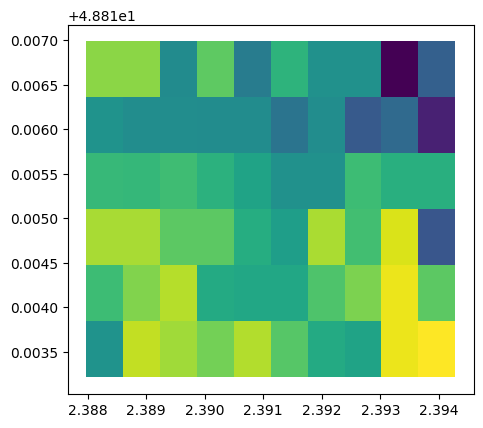

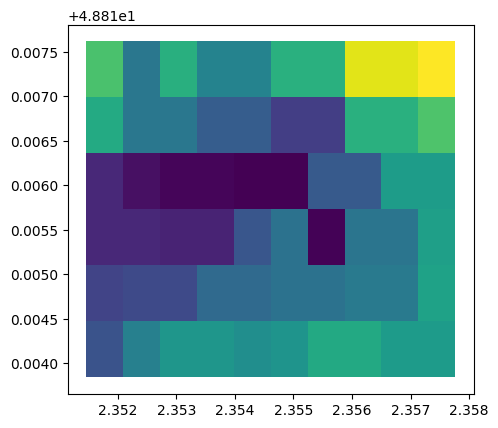

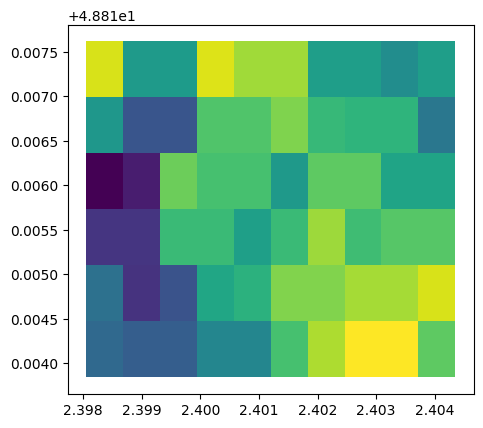

In [13]:
subtiles[random.randint(0,583)].plot(column = 'LST_diff')
subtiles[random.randint(0,583)].plot(column = 'LST_diff')
subtiles[random.randint(0,583)].plot(column = 'LST_diff')

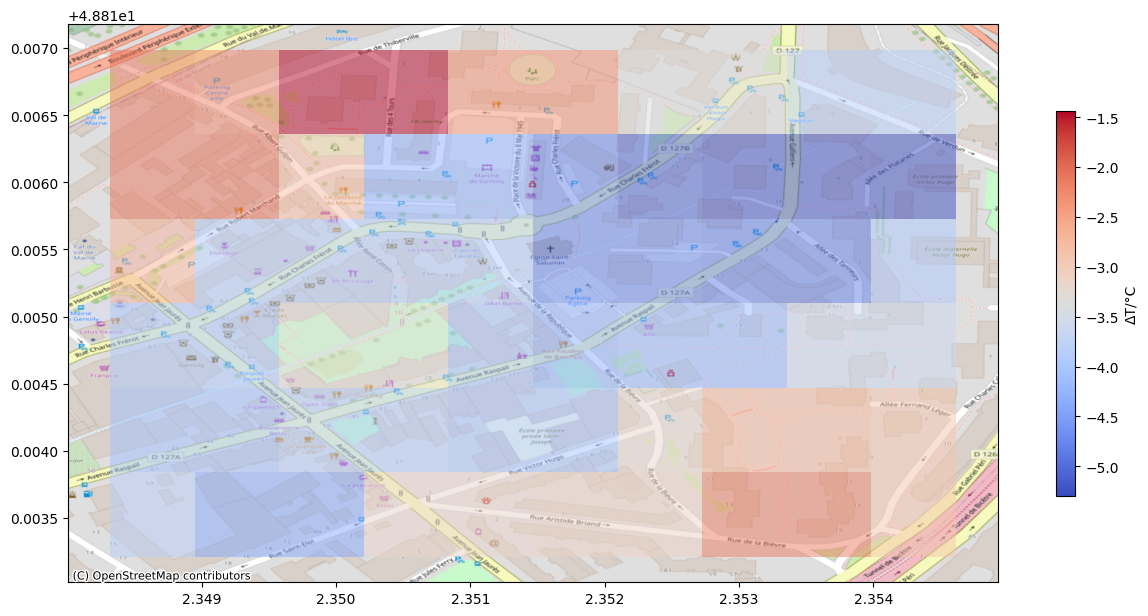

In [25]:
fig, ax = plt.subplots(figsize = (15,10))
subtiles[random.randint(0,583)].plot(column = 'LST_diff', ax = ax, alpha = .5, cmap = 'coolwarm',\
    legend = True,legend_kwds={'shrink': 0.5, 'label': 'ΔT/°C'})
ctx.add_basemap(ax,  crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

In [800]:
import_data_array("Paris")[0,0,0]

array([ -2.315979, -28.184334])

## Export numpy array with all tiles

In [396]:
df_Paris_import.drop(columns=['LST', 'ele','ll_corner', 'ur_corner', 'bb'])

LST_diff   ele_diff                                  ul_corner  \
0     -2.315979 -28.184334  [[2.2633263464873545, 48.81321032181281]]   
1     -2.255981 -28.184212  [[2.2639559127237074, 48.81321032181281]]   
2     -2.355957 -26.814503  [[2.2645854789600603, 48.81321032181281]]   
3     -1.575958 -25.349964  [[2.2652150451964133, 48.81321032181281]]   
4     -2.915985 -25.118069   [[2.265844611432766, 48.81321032181281]]   
...         ...        ...                                        ...   
35023  3.344025  -6.159432  [[2.4188292068665307, 48.90009046242952]]   
35024  2.944031  -5.179237  [[2.4194587731028836, 48.90009046242952]]   
35025  2.944031  -5.179237  [[2.4200883393392365, 48.90009046242952]]   
35026  1.884033  -2.985519  [[2.4207179055755894, 48.90009046242952]]   
35027  1.884033  -2.985519  [[2.4213474718119423, 48.90009046242952]]   

                                        lr_corner  
0      [[2.2639559127237074, 48.813839888049166]]  
1      [[2.2645854789600603, 48.813839888049166]]  
2      [[2.2652150451964133, 48.813839888049166]]  
3       [[2.265844611432766, 48.813839888049166]]  
4       [[2.266474177669119, 48.813839888049166]]  
...                                           ...  
35023   [[2.4194587731028836, 48.90072002866587]]  
35024   [[2.4200883393392365, 48.90072002866587]]  
35025   [[2.4207179055755894, 48.90072002866587]]  
35026   [[2.4213474718119423, 48.90072002866587]]  
35027   [[2.4219770380482952, 48.90072002866587]]  

[35028 rows x 4 columns]

In [86]:
def export_array_subslices(data: pd.DataFrame, number_divisions: int, city: str) -> np.array:
    """
    returns and exports one array containing sub-arrays of all sub-tiles
    """
    
    # drop irrelavant features
    data.drop(columns=['LST', 'ele','ll_corner','lr_corner', 'ur_corner', 'bb'])
    
    # slice coords
    slice_coords = slice_picture_coords(CITY_BOUNDING_BOXES[city], number_divisions)
    
    # get all tiles
    all_tiles = [get_sub_tile(gdf_Paris_import, slice_coords, i) for i in range(50)]
    
    # [print(all_tiles.index(tile), len(tile)) for tile in all_tiles if len(tile) > 50]
    
    return all_tiles

In [87]:
subtiles = export_array_subslices(gdf_Paris_import, 25, "Paris")

In [88]:
pd.DataFrame([len(tile) for tile in subtiles]).value_counts()

40    25
50    25
dtype: int64

In [91]:
(40*25+50*25)/50

45.0

<AxesSubplot: >

<Figure size 1200x700 with 0 Axes>

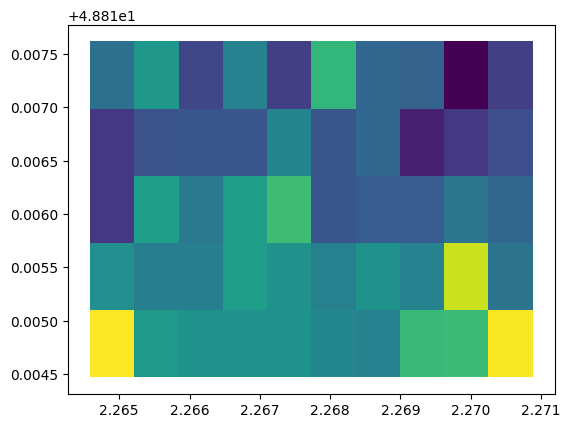

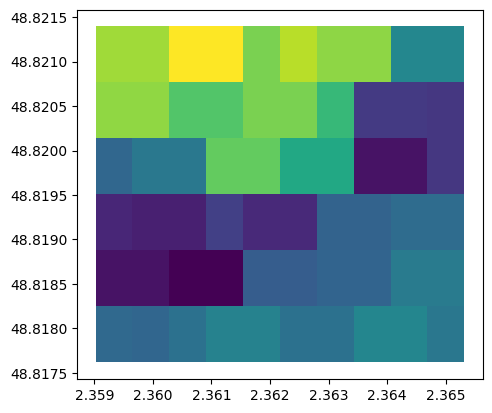

In [ ]:
plt.figure(figsize = (12,7))
subtiles[0].plot(column = 'LST_diff')
subtiles[40].plot(column = 'LST_diff')

## Slicing with overlap

In [30]:
# overlap of 20 percent of small tiles
slice_coords = get_all_sub_coords(df_Paris_import, 10,6, 20)
len(slice_coords)

583

In [51]:
np.array(get_corners([slice_coords[1]]))[0,:,0]

array([2.26269678, 2.26269678, 2.26899244, 2.26899244])

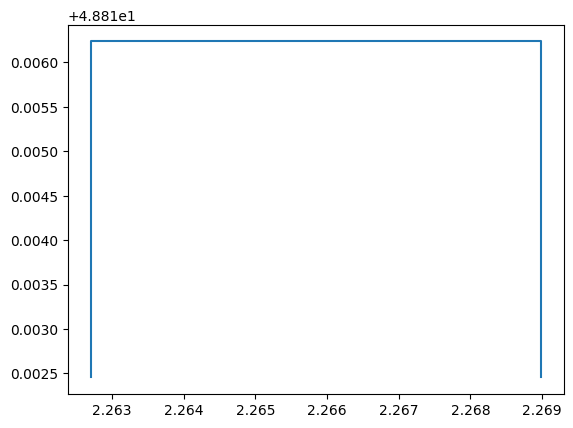

In [53]:
plt.plot(np.array(get_corners([slice_coords[1]]))[0,:,0], np.array(get_corners([slice_coords[1]]))[0,:,1])

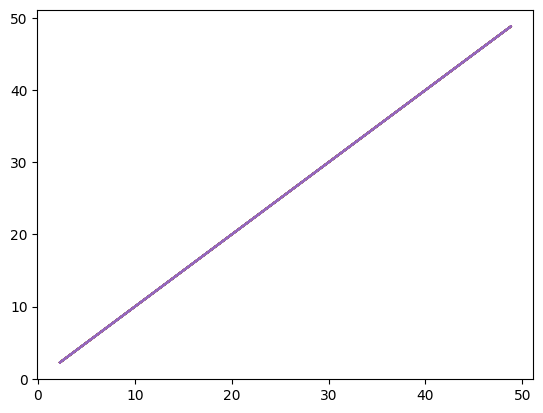

In [35]:
max_tiles = 5
corner_coords = [get_corners([slice_coords[i]]) for i in range(max_tiles)]

x_coords = [np.array(corner_coords)[i,:,0] for i in range(max_tiles)]
y_coords = [np.array(corner_coords)[i,:,1] for i in range(max_tiles)]

for i in range(max_tiles):
    plt.plot(np.append(x_coords[i],x_coords[i][0]),  np.append(y_coords[i],y_coords[i][0]))
